In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from typing import Dict
import os
import sys
import matplotlib.pyplot as plt
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=20)

import numpy as np
import scipy.cluster.hierarchy as hc
import random
import shoji
import loompy

import cytograph as cg
import cytograph.plotting as cgplot

db = shoji.connect()

In [12]:
ws.clusters.length

544

In [66]:
ws = db.builds.humandev_harmony.HumanDevAll
x = ws.Expression[:, ws.Gene == "ASPN"].T[0]
ordering = np.argsort(ws.Clusters[:])

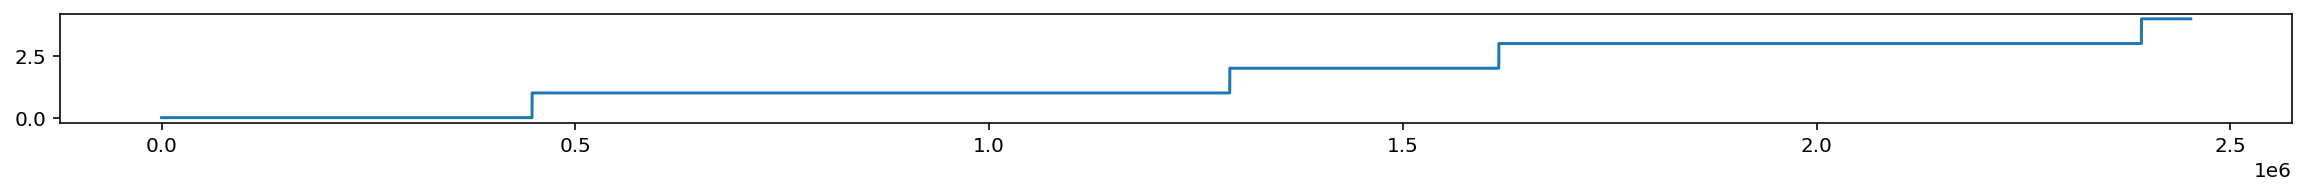

In [68]:
#ASPN
plt.figure(figsize=(20,1))
plt.plot(np.arange(len(x)), ws.Subtree[:][ordering])

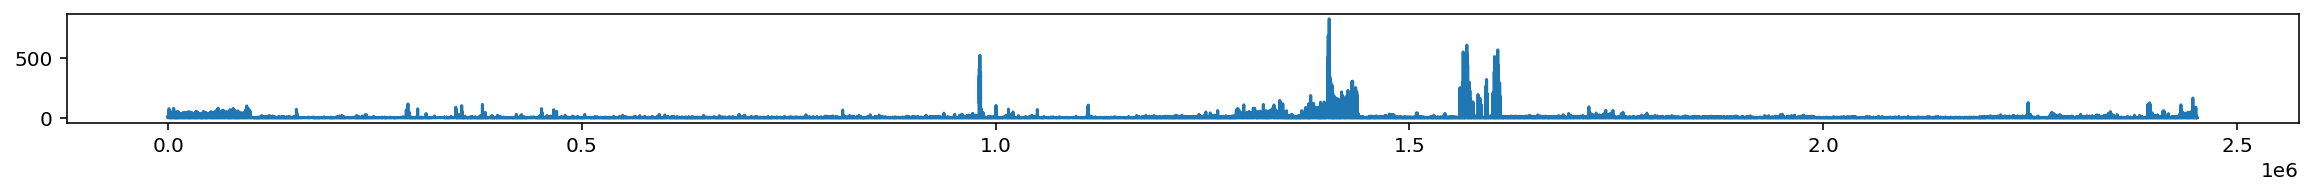

In [65]:
#COL1A2
plt.figure(figsize=(20,1))
plt.plot(np.arange(len(x)), x[ordering])

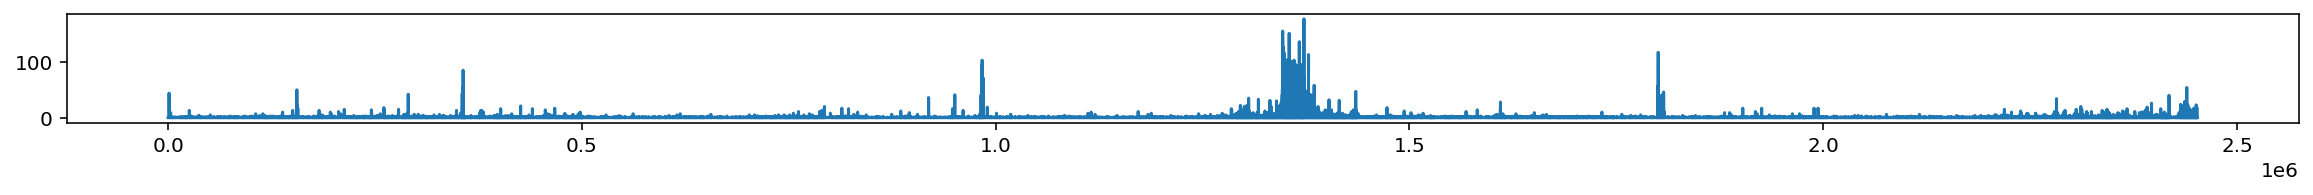

In [63]:
#AIF1
plt.figure(figsize=(20,1))
plt.plot(np.arange(len(x)), x[ordering])

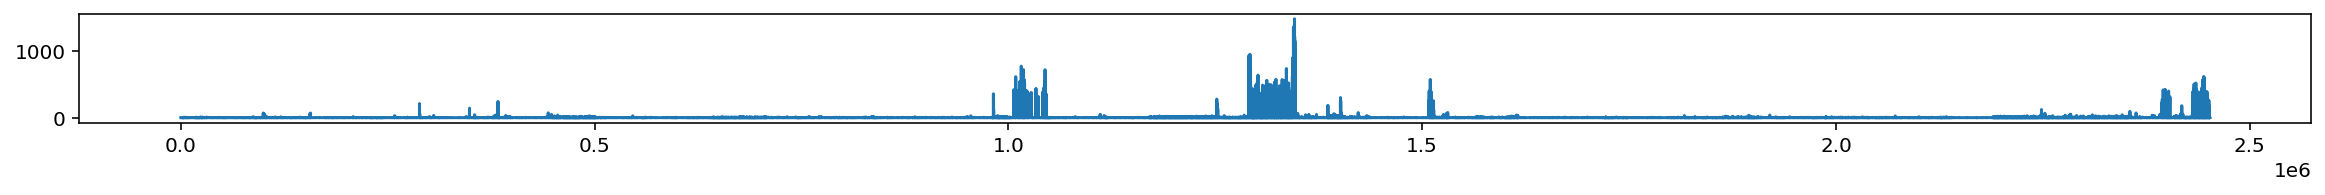

In [61]:
#CLDN5
plt.figure(figsize=(20,1))
plt.plot(np.arange(len(x)), x[ordering])

(-34.67936973571777, 43.48277549743652, -41.60002498626709, 38.70713787078857)

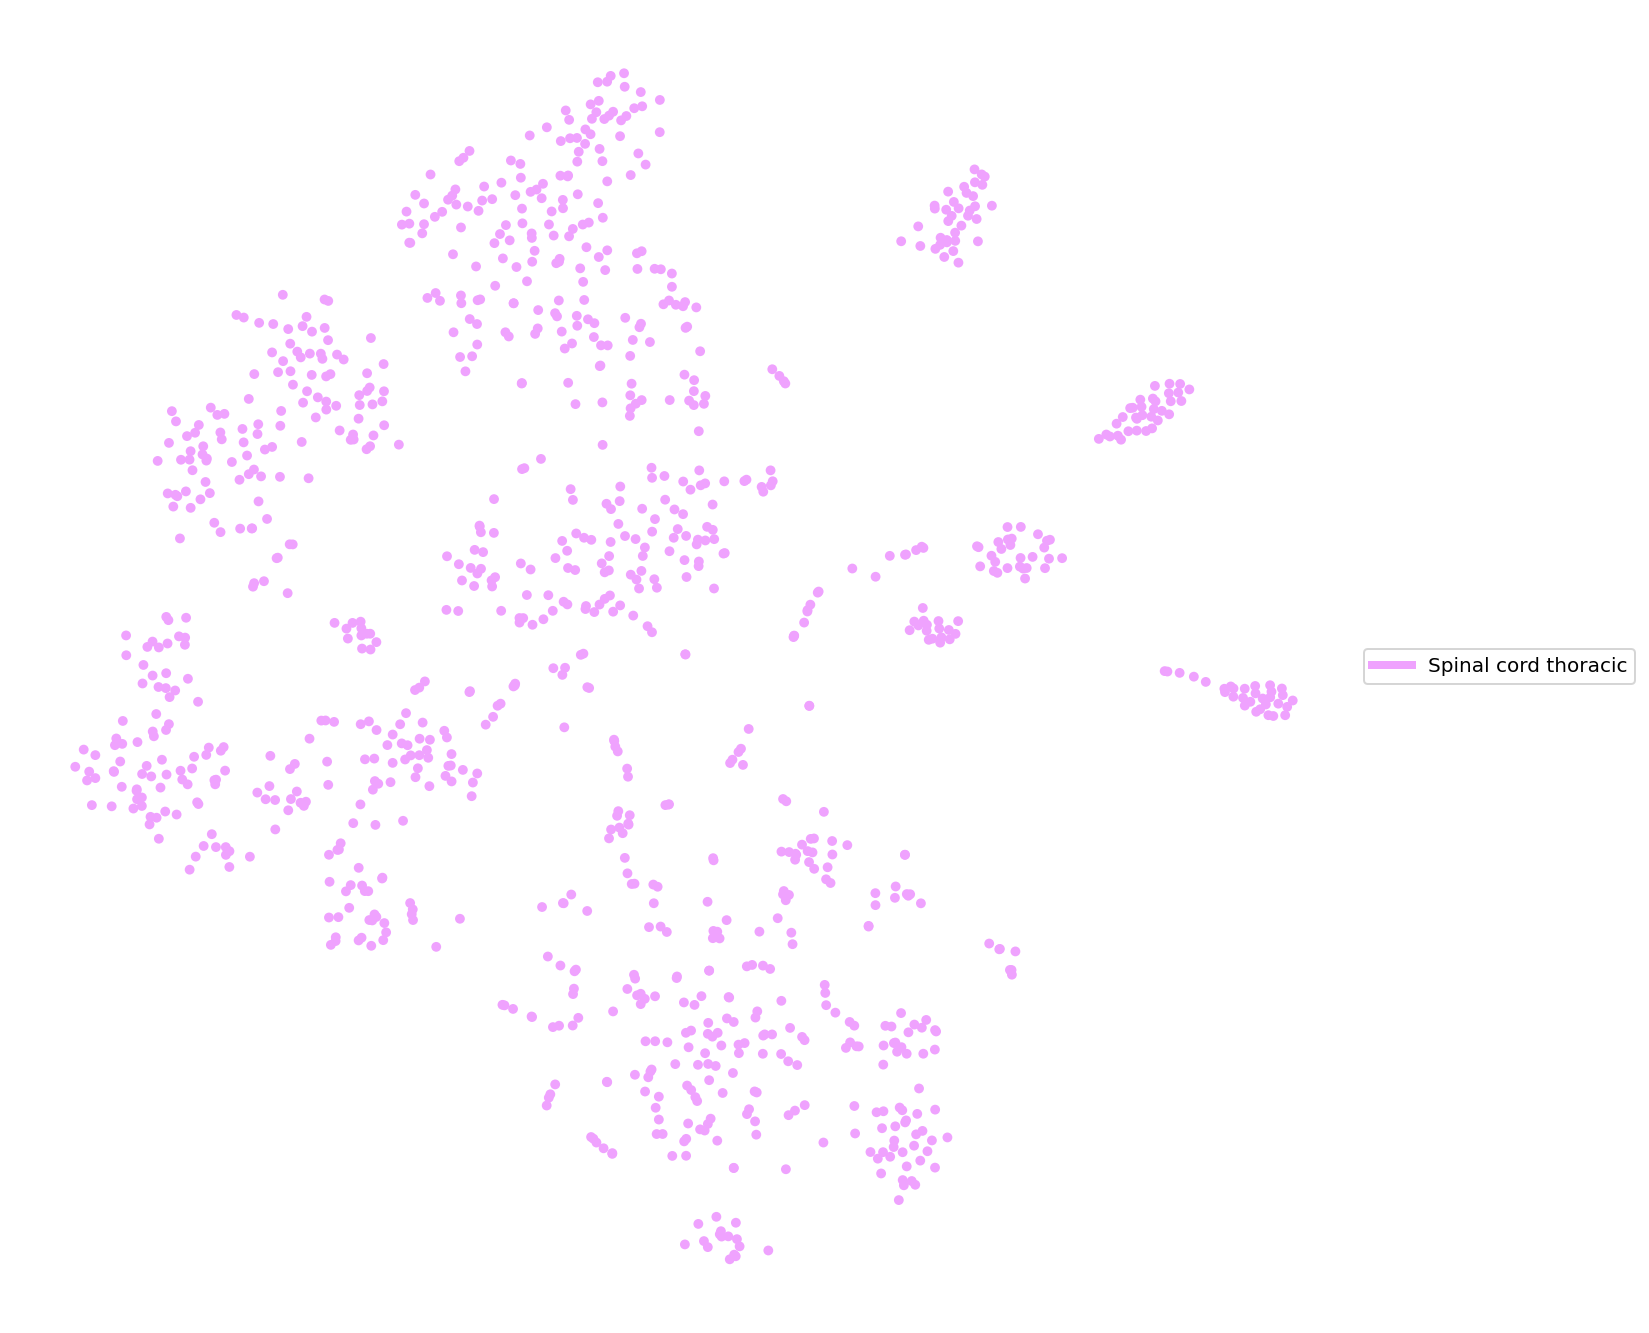

In [24]:
ws = db.builds.humandev_harmony.HumanDev1
plt.figure(figsize=(12,12))
cgplot.scatterc(ws.Embedding[:], c=ws.Tissue[:], s=24)
plt.axis("off")

(-34.67936973571777, 43.48277549743652, -41.60002498626709, 38.70713787078857)

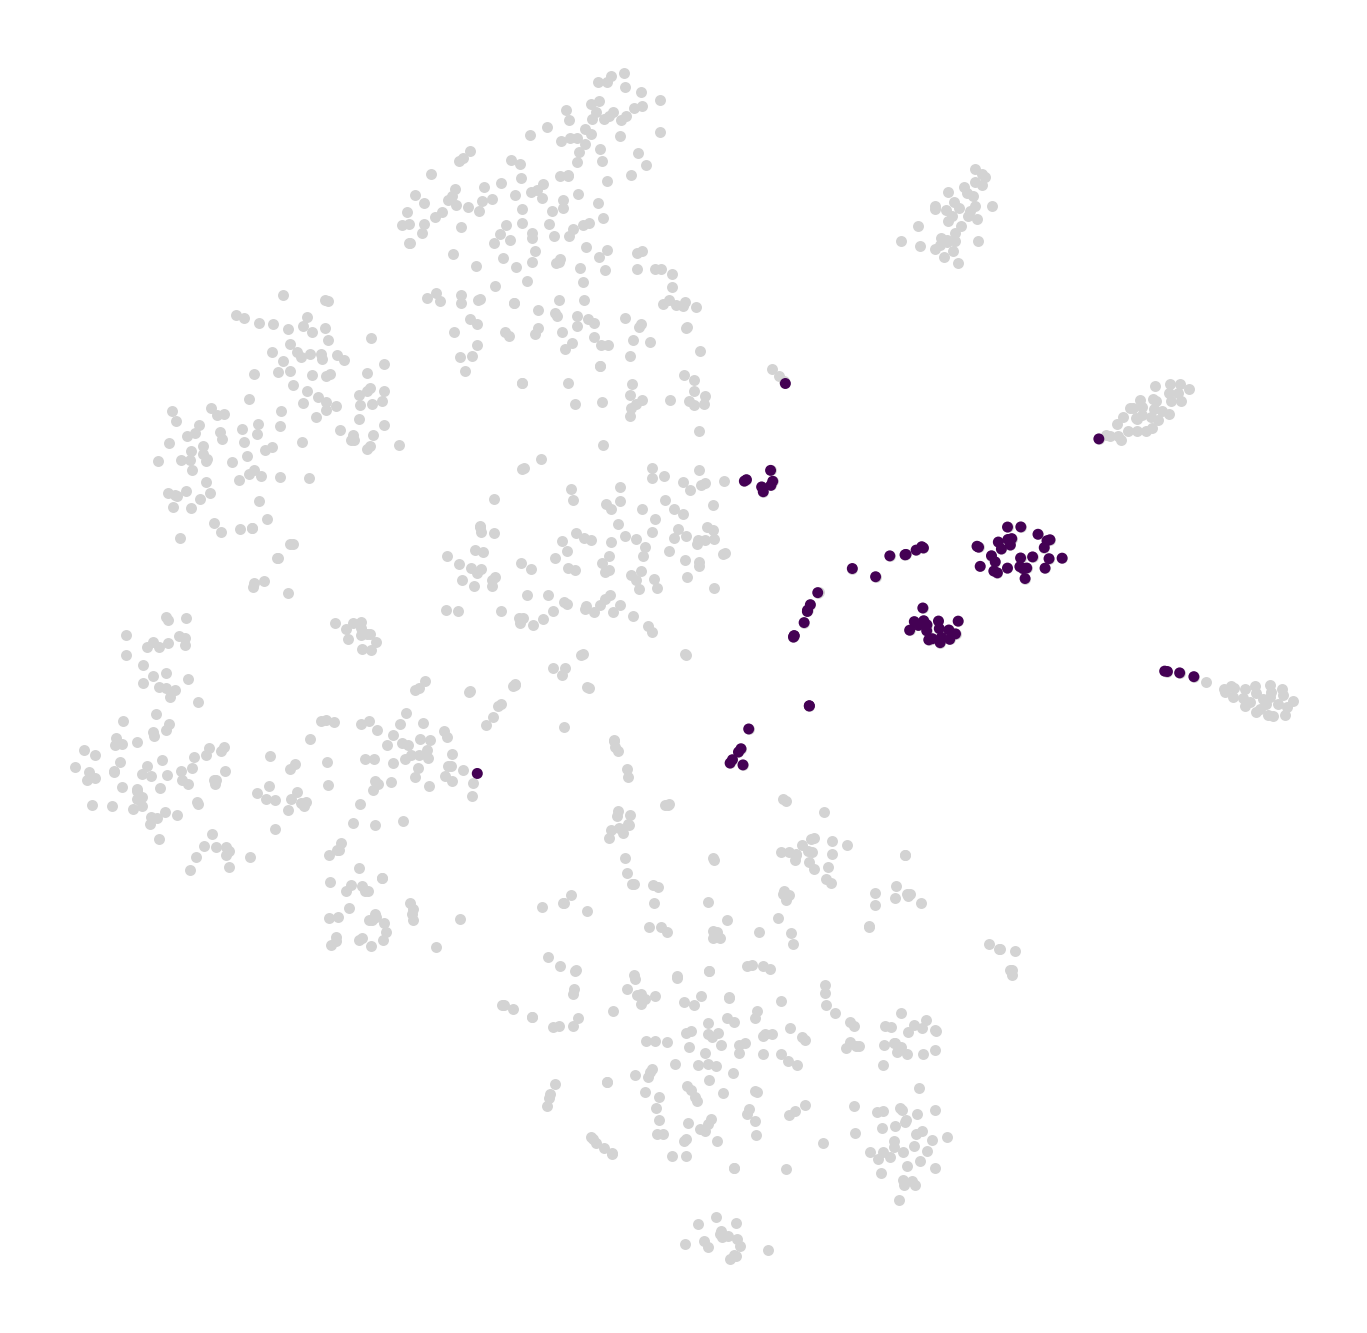

In [32]:
ws = db.builds.humandev_harmony.HumanDev1
plt.figure(figsize=(12,12))
cgplot.scattern(ws.Embedding[:], c=ws.Subtree[:] == 4, s=30)
plt.axis("off")

In [20]:
st=ws.Subtree[:]

In [22]:
st[np.argsort(ws.Clusters[:])]

array([0, 0, 0, ..., 4, 4, 4], dtype=uint32)

(-24.034704208374023,
 27.672731399536133,
 -24.556788635253906,
 22.49452133178711)

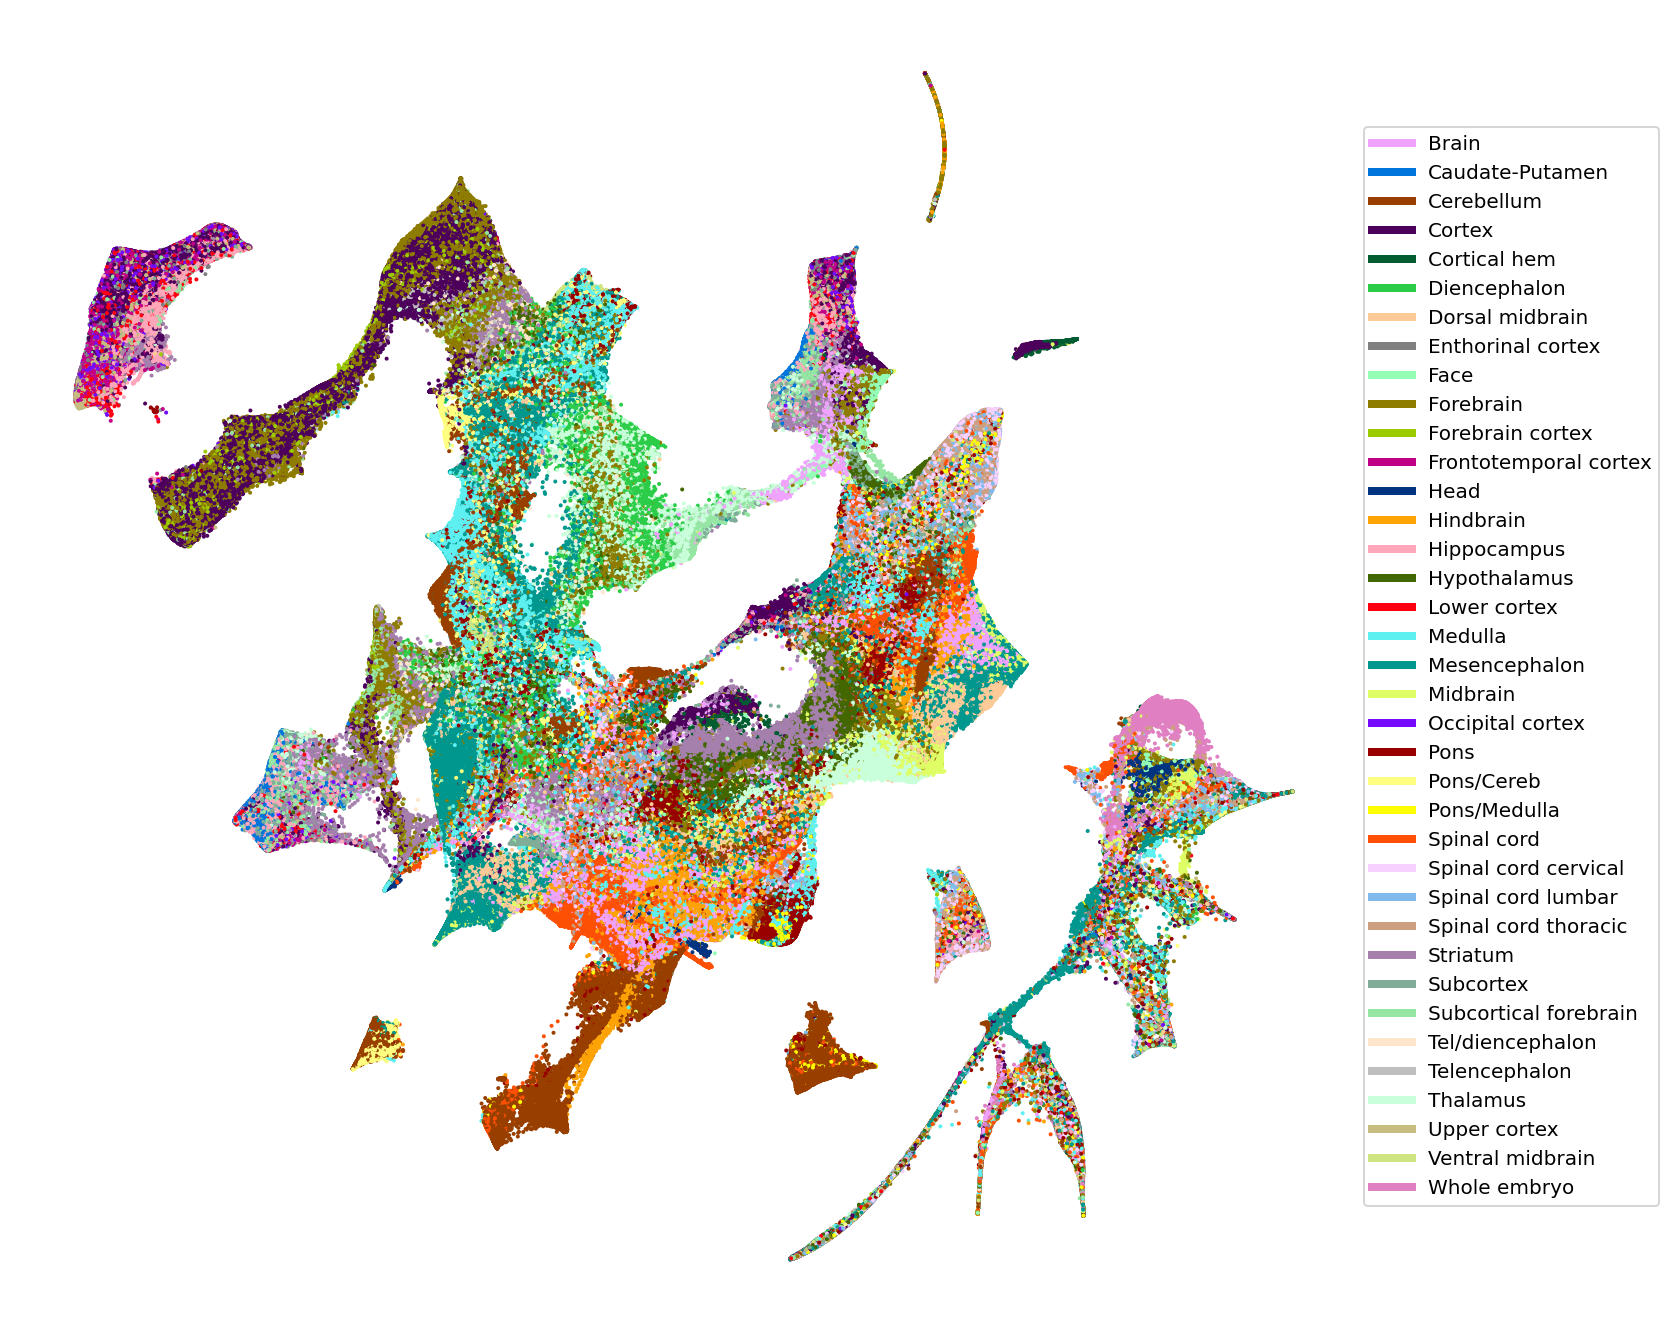

In [8]:
ws = db.builds.humandev.HumanDevAll
plt.figure(figsize=(12,12))
cgplot.scatterc(ws.Embedding[:], c=ws.Tissue[:], s=4)
plt.axis("off")

In [86]:
class Heatmap:
    def __init__(self):
        pass

    def plot(self, ws: shoji.WorkspaceManager, out_file=None):
        # Load data
        genes = ws.Gene[:]
        ordering = np.argsort(ws.ClusterID[:])
        mean_x = ws.MeanExpression[:][ordering]
        enrichment = ws.Enrichment[:][ordering]
        markers = cg.Species(ws.Species[:]).markers
        
        # Compute the main heatmap
        enriched_genes = []
        x = []
        for i in range(enrichment.shape[0]):
            count = 0
            for gene in genes[np.argsort(-enrichment[i, :])]:
                gene_ix = np.where(genes == gene)[0][0]
                if gene not in enriched_genes:
                    enriched_genes.append(gene)
                    x.append(mean_x[:, gene_ix])
                    count += 1
                if count == 3:
                    break
        x = np.array(x)  # x is (n_genes, n_clusters)
        enriched_genes = np.array(enriched_genes)
        # Rearrange the genes by the max-expressing cluster
        top_cluster = []
        for g in enriched_genes:
            top_cluster.append(np.argsort(-enrichment[:, genes == g].T[0])[0])
        gene_ordering = np.argsort(top_cluster)
        x = x[gene_ordering, :]
        enriched_genes = enriched_genes[gene_ordering]
        # Add the markers
        m = []
        m_names = []
        for category, mgenes in markers.items():
            for gene in mgenes:
                gene_ix = np.where(genes == gene)[0][0]
                m.append(mean_x[:, gene_ix])
                m_names.append(gene)
        x = np.vstack([m, x])
        enriched_genes = np.concatenate([m_names, enriched_genes])
        # Normalize
        totals = mean_x.sum(axis=1)
        x_norm = (x / totals * np.median(totals)).T
        x_norm = x_norm / np.max(x_norm, axis=0)        

        # Set up the figure
        n_genes = x.shape[0]
        n_clusters = ws.clusters.length
        dendrogram_height = n_genes / 40
        fig_width = n_clusters / 40
        fig_height = dendrogram_height + (1 + 2 + n_genes) / 40
        fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
        
        heights = [dendrogram_height] + [1, 2, n_genes]
        fig_spec = fig.add_gridspec(nrows=4, height_ratios=heights)
        fig_spec.hspace = 0
        fig_spec.wspace = 0
        subplot = 0
        
        # Plot the dendrogram
        ax = fig.add_subplot(fig_spec[subplot])
        z = ws.Linkage[:].astype("float64")
        lines = cgplot.dendrogram(z)
        lines.set_linewidth(0.5)
        ax.add_collection(lines)
        ax.set_xlim(-0.5, ws.clusters.length - 0.5)
        ax.set_ylim(0, z[:, 2].max() * 1.1)
        plt.axis("off")
        subplot += 1
               
        # Plot the stripe of ages
        ages = ws.MeanAge[:][ordering]
        ax = fig.add_subplot(fig_spec[subplot])
        ax.imshow(ages[None, :], cmap="rainbow", vmin=min(ages[ages > 0]), vmax=max(ages))
        ax.set_xlim(-0.5, n_clusters - 0.5)
        plt.axis("off")
        subplot += 1

        # Plot the barchart of cluster sizes
        n_cells = ws.NCells[:][ordering]
        ax = fig.add_subplot(fig_spec[subplot])
        ax.bar(np.arange(n_clusters), n_cells, color="grey")
        ax.set_xlim(-0.5, n_clusters - 0.5)
        plt.axis("off")
        subplot += 1

        # Plot the heatmap
        ax = fig.add_subplot(fig_spec[subplot])
        ax.set_anchor("N")
        ax.imshow(x_norm.T, vmax=1, cmap="cividis", interpolation="none", aspect="equal")
        ax.set_yticks(np.arange(x_norm.shape[1]))
        ax.set_yticklabels(enriched_genes, fontsize=2)
        for ix, label in enumerate(enriched_genes):
            if ix < len(enriched_genes) - 21:
                ax.text(np.argmax(x_norm[:, ix]) + 0.5, ix+0.3, label, fontsize=2, color="white")
            else:
                ax.text(np.argmax(x_norm[:, ix]) - 0.5, ix + 0.3, label, fontsize=2, color="white", ha="right")

        plt.tight_layout()
        plt.subplots_adjust(hspace=0, left=0, right=1, top=1, bottom=0)
        if out_file is not None:
            plt.savefig(out_file, dpi=400, bbox_inches='tight')
            plt.close()

In [102]:
d = "/Users/stelin/cytograph/humandev_harmony/exported/"
punchcard = "HumanDevSplitA4"
Heatmap().plot(db.builds.humandev_harmony[punchcard], d + punchcard + "/" + punchcard + "_heatmap.png")

<ipython-input-86-45b6edd975cc>:48: RuntimeWarning: invalid value encountered in true_divide
  x_norm = x_norm / np.max(x_norm, axis=0)


In [109]:
db.builds.humandev_harmony.HumanDevAll.clusters.length

544

In [108]:
161+345+233+248+56

1043

In [94]:
import h5py
f = h5py.File("/Users/stelin/Downloads/TabulaSapiens.h5ad", "r")

In [101]:
f["X"].keys()

<KeysViewHDF5 ['data', 'indices', 'indptr']>

In [223]:
ws = db.builds.humandev_harmony.HumanDevAll
a = ws[ws.Clusters == 2, ws.Gene == "PLP1"].Expression
ws = db.builds.humandev_harmony.HumanDevSplitA0
b = ws[ws.PrevClusters == 2, ws.Gene == "PLP1"].Expression

In [224]:
np.all(a == b)

True

In [58]:
from scipy.cluster.hierarchy import cut_tree

ws = db.builds.humandev.HumanDevAll
z = ws.Linkage[:].astype("float64")

subtrees = cut_tree(z, n_clusters=4).T[0]
for i in range(4):
    print(i, (subtrees == i).sum())

ws = db.builds.humandev.HumanDevSplitA3
print(ws.clusters.length)

0 218
1 80
2 190
3 72
48


Text(0, 0.5, 'Fraction zeros')

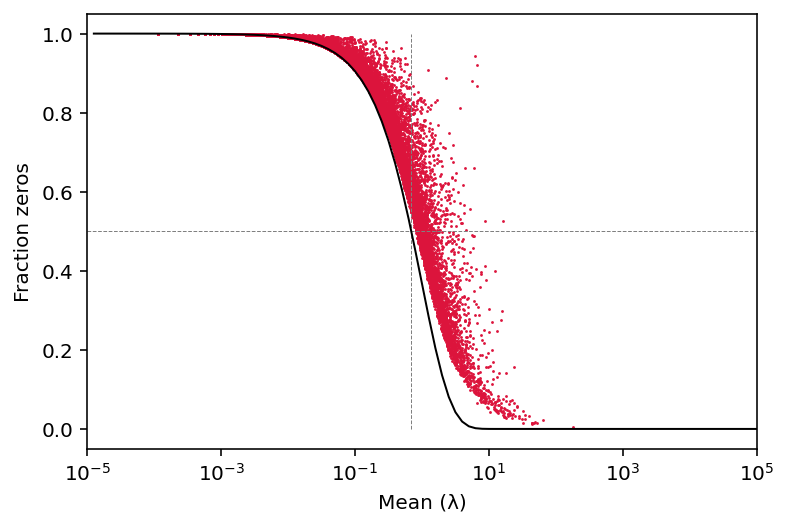

In [29]:
ws = db.samples.TenX288_7
view = ws[:]
plt.hlines(0.5, 1e-5, 1e5, color="grey", lw=0.5, ls="--")
plt.vlines(0.69, 0, 1, color="grey", lw=0.5, ls="--")
plt.scatter(view.GeneTotalUMIs[:] / ws.cells.length, 1-(view.Nonzeros[:] / ws.cells.length), s=2, lw=0, color="crimson")
x = np.array([10**-x for x in np.arange(-5, 5, 0.1)])
plt.plot(x, np.exp(-x), color="black", lw=1)
plt.xscale("log")
plt.xlim(1e-5,1e5)
plt.xlabel("Mean (λ)")
plt.ylabel("Fraction zeros")

In [122]:
# For Poisson distribution:
# lambda == -ln(fraction_zero)

import torch
from tqdm import trange

class Umify:
    def __init__(self, x: np.ndarray, device: str = "cpu") -> None:
        n_cells, n_genes = x.shape
        self.u = torch.tensor(np.random.uniform(-1, 1, size=(n_cells,1)), device=device, requires_grad=True, dtype=torch.float32)
        self.v = torch.tensor(np.random.uniform(-1, 1, size=(1, n_genes)), device=device, requires_grad=True, dtype=torch.float32)
        self.expected_lambda = -torch.log(torch.tensor(1 - np.count_nonzero(x, axis=0) / n_cells, device=device, dtype=torch.float32))
        self.x = torch.tensor(x.astype("float32"), device=device, dtype=torch.float32)
        self.losses = []

    def _loss_fn(self) -> np.ndarray:
        n_cells, n_genes = self.x.shape
        lambda_ = (self.x * torch.nn.Sigmoid()(self.u).expand(-1, n_genes) * torch.nn.Sigmoid()(self.v).expand(n_cells, -1)).mean(axis=0)
        loss = torch.nn.MSELoss()(lambda_, self.expected_lambda)
        return loss

    def fit(self, num_epochs: int = 100, learning_rate: float = 0.1) -> "BoneFight":
        """
        Fit the Umify model

        Args:
            num_epochs		Number of epochs
            learning_rate	Learning rate (default: 0.1)
        """
        optimizer = torch.optim.Adam([self.u, self.v], lr=learning_rate)
        with trange(num_epochs) as t:
            for _ in t:
                loss = self._loss_fn()
                lossn = loss.detach().numpy()
                t.set_postfix(loss=lossn)
                self.losses.append(lossn)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        u = torch.nn.Sigmoid()(self.u.detach()).numpy()
        v = torch.nn.Sigmoid()(self.v.detach()).numpy()
    
        # Rescale so that u.mean() is 1
        return u / u.mean(), v * u.mean()

In [5]:
x=view.Expression[:]

In [123]:
umify = Umify(x)
u, v = umify.fit(100)

100%|██████████| 100/100 [25:18<00:00, 15.18s/it, loss=3.8838508]


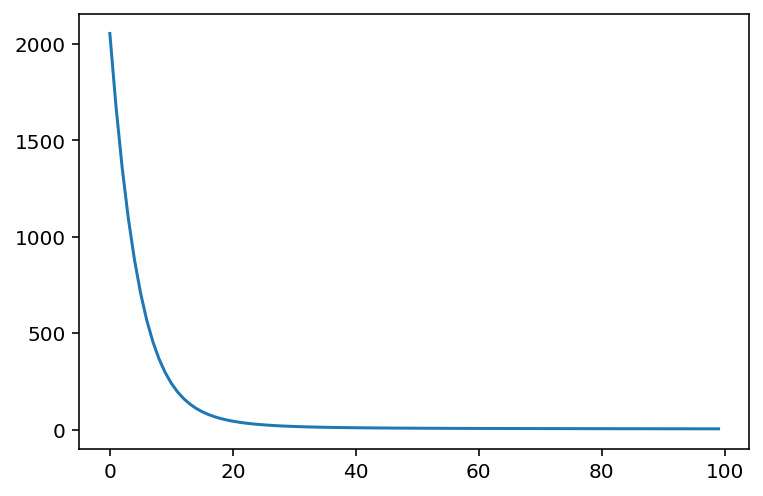

In [124]:
plt.plot(umify.losses)

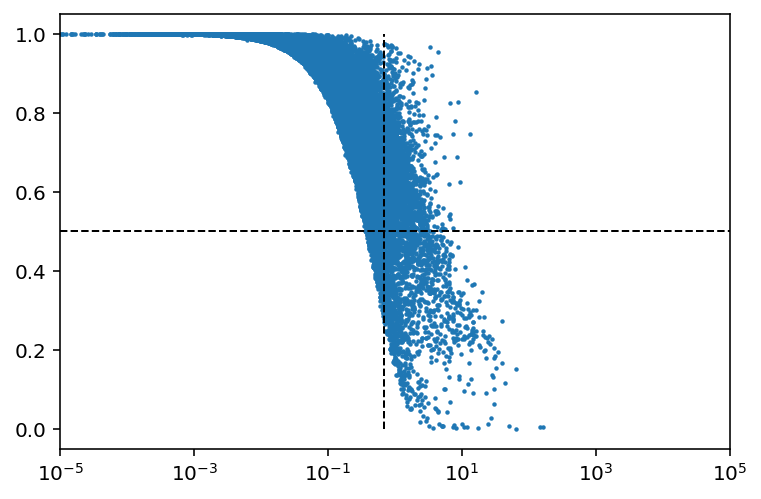

In [125]:
nx = x * u * v
plt.scatter(nx.sum(axis=0) / nx.shape[0], 1 - (np.count_nonzero(nx, axis=0) / nx.shape[0]), s=5, lw=0)
plt.xscale("log")
plt.xlim(1e-5,1e5)
plt.hlines(0.5, 1e-5, 1e5, linestyles="--", lw=1)
plt.vlines(0.69, 0, 1, linestyles="--", lw=1)

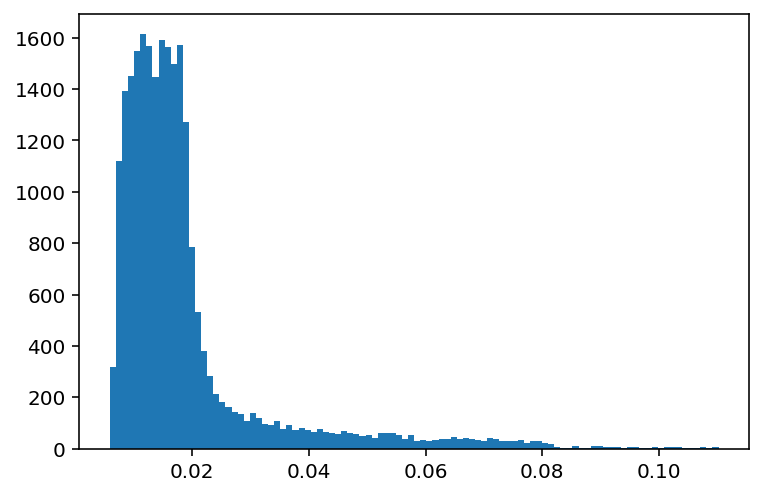

In [128]:
plt.hist(v[0], bins=100)
None

In [19]:
nx

NameError: name 'nx' is not defined

In [129]:
edges = 238472983745
f"{edges:,} edges"

'238,472,983,745 edges'

In [131]:
type(max(1, 10 // 3))

int

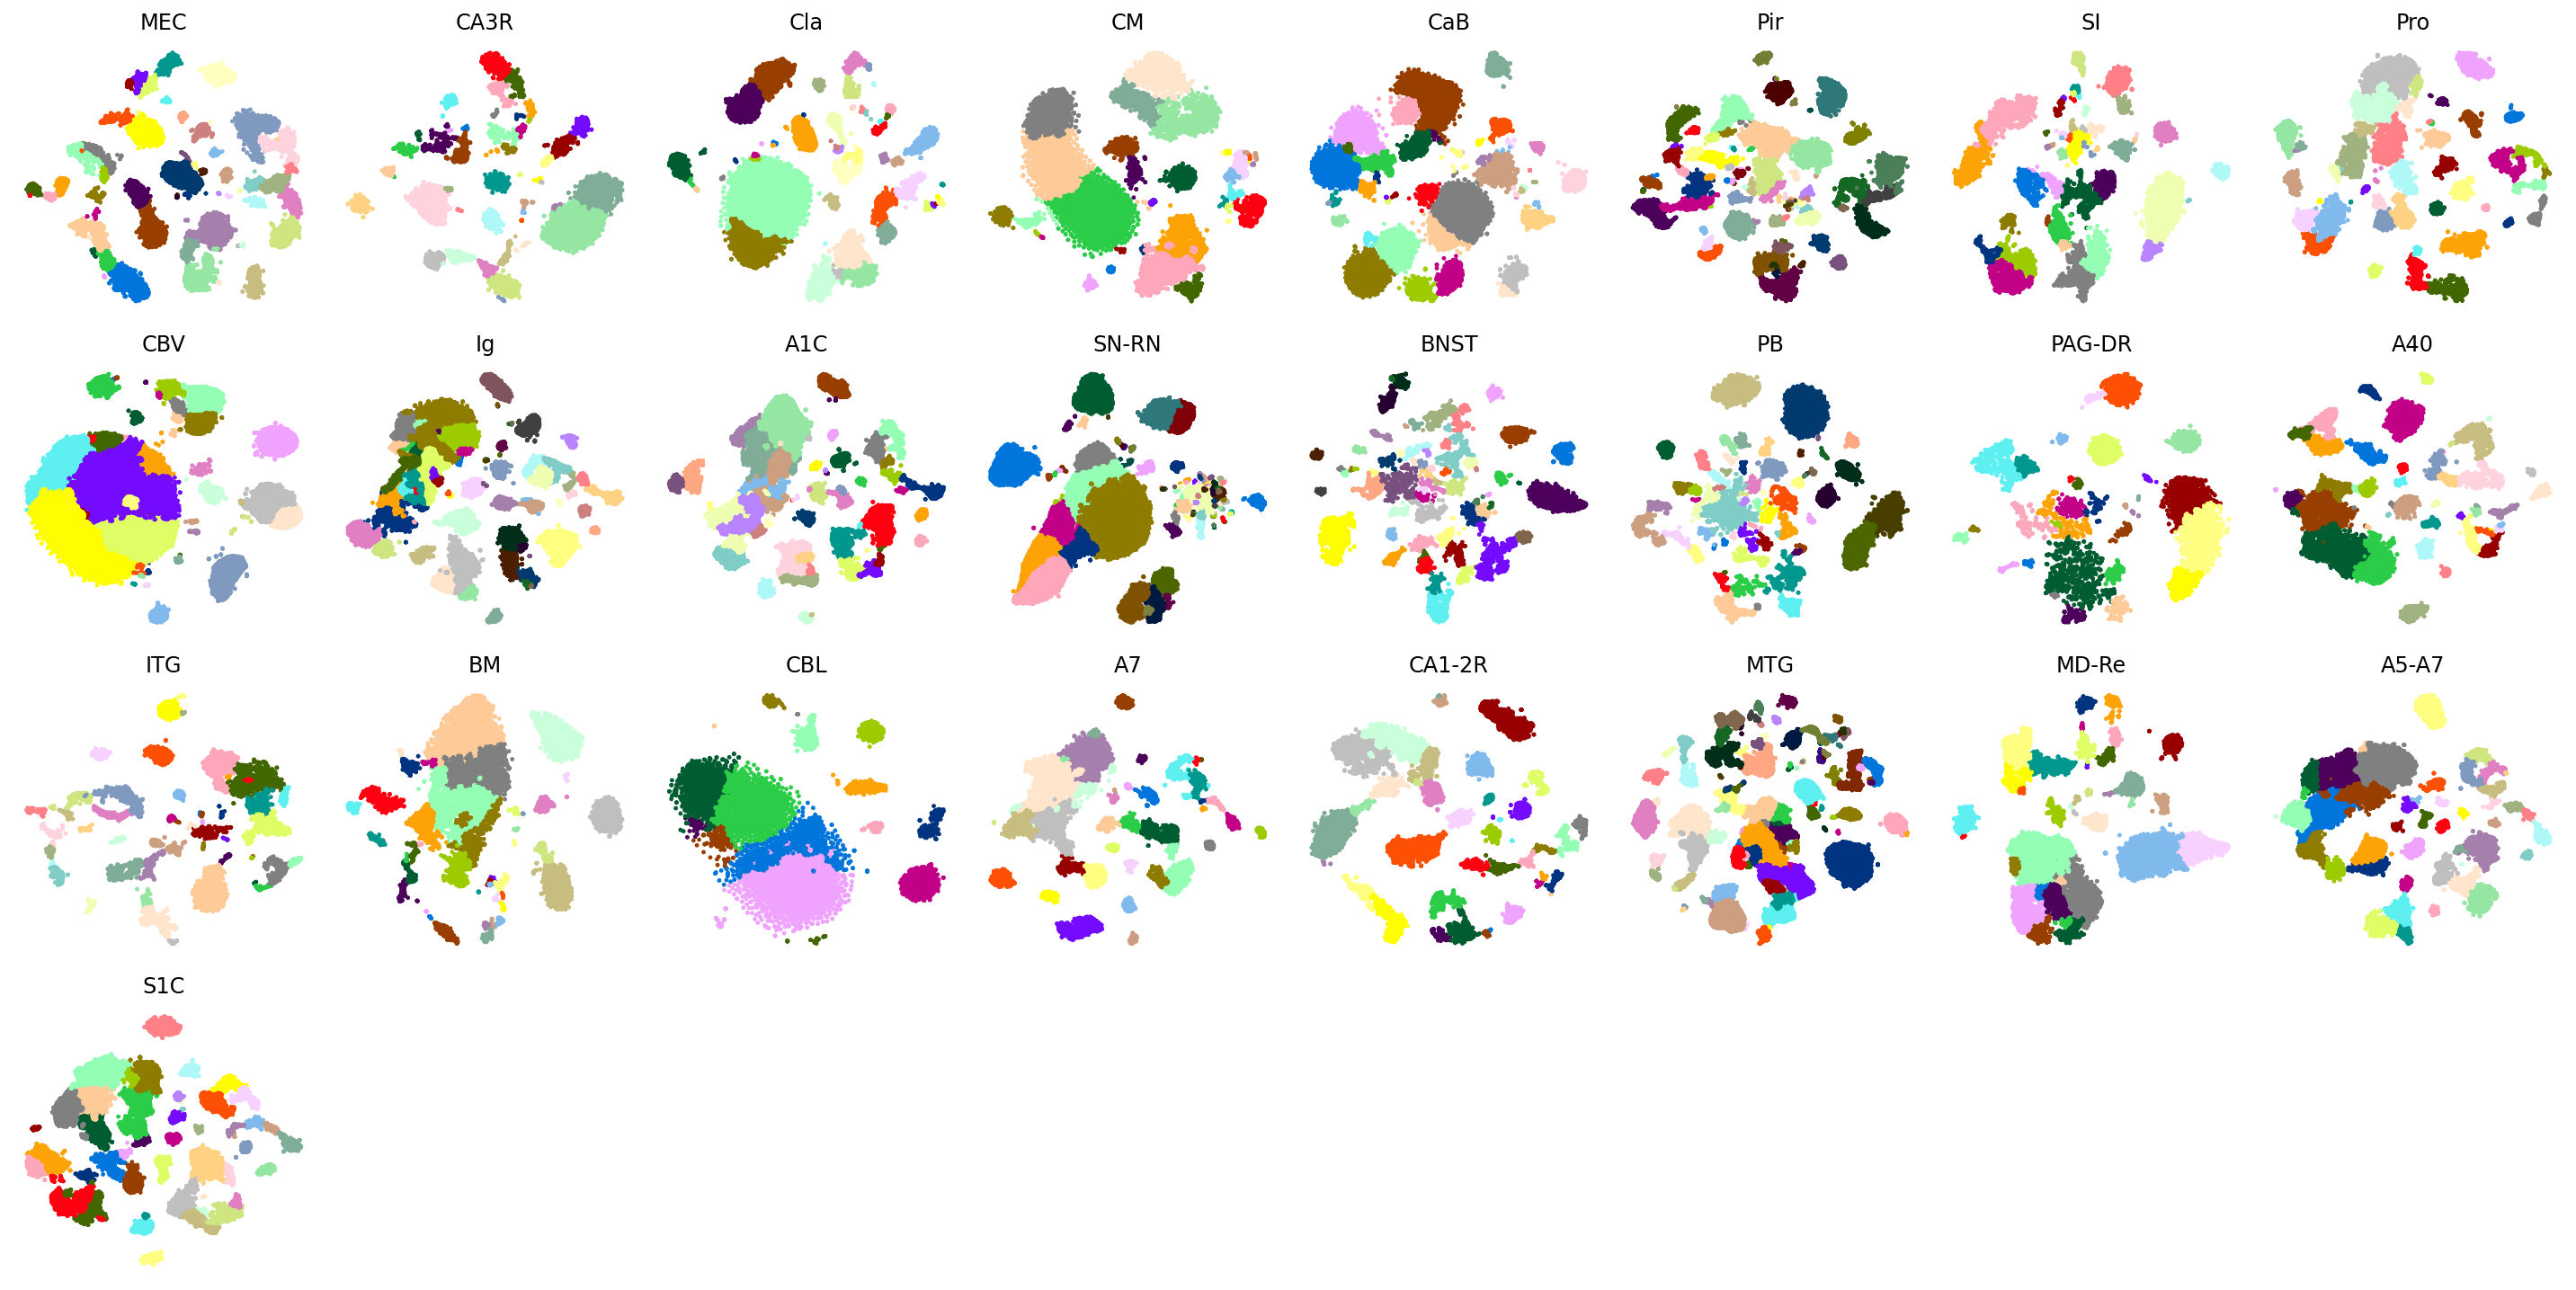

In [167]:
d = "/Users/stelin/cytograph/human_adult_Regions_20210201/data/"
plt.figure(figsize=(20,20))
i = 1
for f in os.listdir(d):
    if f.endswith("NoDoub.loom"):
        try:
            with loompy.connect(d + f) as ds:
                plt.subplot(8, 8, i)
                plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=cgplot.colorize(ds.ca.Clusters), s=2)
                plt.axis("off")
                plt.title(f.split("_")[0])
            i += 1
            if i > 25:
                break
        except:
            print(f)
            continue
plt.tight_layout()

In [197]:
import numpy as np
import laspy as lp
point_cloud=lp.file.File("/Users/stelin/Downloads/2020_Drone_M.las", mode="r")

In [198]:
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
colors = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()

In [199]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors/65535)
#pcd.normals = o3d.utility.Vector3dVector(normals)
o3d.visualization.draw_geometries([pcd])

In [200]:
points.shape

(20152365, 3)